In [3]:
import os
import io
import itertools
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

materials_data_dir=Path(os.getcwd())/'materials_data'
# items_data_dir=Path(os.getcwd())/'items_data'

materials_images_dir= materials_data_dir/'images'
materials_train_dir= materials_data_dir/'train'
materials_valid_dir= materials_data_dir/'valid'
materials_test_dir= materials_data_dir/'test'

# items_images_dir= items_data_dir/'images'
# items_train_dir= items_data_dir/'train'
# items_valid_dir= items_data_dir/'valid'
# items_test_dir= items_data_dir/'test'

model_dir = Path(os.getcwd())/'models'
save_model_materials_dir = model_dir/'materials'
# save_model_items_dir = model_dir/'items'
lite_models_dir = model_dir/'lite'

logs_dir = Path(os.getcwd())/'logs'
materials_log = logs_dir/'materials'
# items_log = logs_dir/'items'

project_dir=[
  materials_data_dir,
  materials_images_dir,
  materials_train_dir,
  materials_valid_dir,
  materials_test_dir,

  # items_data_dir,
  # items_images_dir,
  # items_train_dir,
  # items_valid_dir,
  # items_test_dir,

  model_dir,
  save_model_materials_dir,
  # save_model_items_dir,
  lite_models_dir,

  logs_dir,
  materials_log,
  # items_log
]

print(f"Scanning for necessary directories")
for dir_path in project_dir:
    if os.path.exists(dir_path):
        print(f"Found directory {dir_path}")
    else:
        print(f"Creating '{dir_path}' directory at project's root")
        os.mkdir(dir_path)

Scanning for necessary directories
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/images
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/train
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/valid
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/test
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/models
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/models/materials
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/models/lite
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/logs
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/logs/materials


In [3]:
from src.helpers import split_train_valid_test

split_train_valid_test(
    materials_images_dir,
    materials_train_dir,
    materials_valid_dir,
    materials_test_dir,
    0.7,
    0.15
)

Total images found: 995
Train: 696, Validation: 149, Test: 150
Copying 696 of 995 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/train/paper
Copying 149 of 995 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/valid/paper
Copying 150 of 995 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/test/paper
Total images found: 410
Train: 287, Validation: 61, Test: 62
Copying 287 of 410 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/train/metal
Copying 61 of 410 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/valid/metal
Copying 62 of 410 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/test/metal
Total images found: 137
Train: 95, Validation: 20, Test: 22
Copying 95 of 137 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/train/trash
Copying 20 of 137 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/materials_data/valid/trash
Copying 22 of 137 to /Users/jo

In [4]:
from src.model_builder.RobinMobilenetV2 import RobinMobilenetV2
from typing import List
from src.utils import extract_truth_and_predictions, plot_confusion_matrix, log_confusion_matrix, log_wrongly_classified_images

def get_ds(dir, hyperparams):
    pipe = lambda path: image_dataset_from_directory(
        path,
        shuffle=True,
        label_mode='categorical',
        batch_size = hyperparams['batch_size'],
        image_size = hyperparams['img_size']
    )
    return [ pipe(path) for path in dir ]

def train_new_materials_model(hyperparams, datasets, log_dir, training_tag):
    image_shape = (*hyperparams["img_size"], hyperparams['channels'])
    class_count = len(datasets['class_names'])
    model = RobinMobilenetV2(image_shape, class_count)
    model().summary()
    model().compile(
        optimizer=tf.keras.optimizers.Adam(lr=hyperparams["base_learning_rate"]),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    history = model().fit(
        x=datasets['train_ds'],
        epochs=hyperparams['initial_epochs'],
        validation_data=datasets['validate_ds'],
        callbacks=[TensorBoard(os.path.join(log_dir, 'fit', f'new_{training_tag}'))]
    )
    return model, history

def fine_tune_materials_model(model, hyperparams, datasets, history, log_dir, training_tag):
    print("Fine tuning")
    model.base_model.trainable = True # Setting base model to be trainable again
    fine_tune_from = 100 # Fine-tune from this layer onwards
    for layer in model.base_model.layers[:fine_tune_from]: # Freeze all the layers before the `fine_tune_from` layer
      layer.trainable =  False

    model().compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(lr=hyperparams['base_learning_rate']/10),
        metrics=['accuracy']
    )
    model().summary()

    total_epochs = hyperparams["initial_epochs"] + hyperparams["fine_tune_epochs"]
    history_fine_tune = model().fit(
        x=datasets['train_ds'],
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
        validation_data=materials_validation_ds,
        callbacks=[TensorBoard(os.path.join(log_dir, 'fit', f'finetune_{training_tag}'))]
    )

    return history_fine_tune

def evaluate_model(model: tf.keras.Model, test_ds, class_names: List[str], log_dir: str, training_tag, cm_name: str, log_false_images = False):
    model.evaluate(x=test_ds)
    (
        labels, predictions,
        (wrongly_classified_images, wrong_predictions)
    ) = extract_truth_and_predictions(model, test_ds)

    cm_figure = plot_confusion_matrix(
        cm = tf.math.confusion_matrix(labels, predictions).numpy(),
        class_names = class_names
    )

    logdir = str(log_dir) if isinstance(log_dir, Path) else log_dir

    log_confusion_matrix(os.path.join(logdir, 'cm', training_tag), cm_name, cm_figure)

    if log_false_images:
        log_wrongly_classified_images(
            classnames=class_names,
            wrong_predictions = wrong_predictions,
            wrong_images = wrongly_classified_images.astype('uint8'),
            logdir_path=os.path.join(log_dir, 'images', training_tag)
        )

In [6]:
materials_hyperparams = {
    "img_size": (160, 160),
    "channels": 3,
    "batch_size": 32,
    "base_learning_rate": 0.0001,
    "initial_epochs": 3,
    "fine_tune_epochs": 3
}

materials_train_ds, materials_validation_ds, materials_test_ds = get_ds(
    [materials_train_dir, materials_valid_dir, materials_test_dir],
    materials_hyperparams
)

materials_dataset = {
    "train_ds": materials_train_ds,
    "validate_ds": materials_validation_ds,
    "test_ds": materials_test_ds,
    "class_names": materials_train_ds.class_names
}

materials_logdir = materials_log
training_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

Found 1766 files belonging to 5 classes.
Found 377 files belonging to 5 classes.
Found 384 files belonging to 5 classes.


In [7]:
(robin_materials_model, history) = train_new_materials_model(
    materials_hyperparams,
    materials_dataset,
    log_dir=materials_logdir,
    training_tag=training_tag
)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

12/12 [==============================] - 4s 313ms/step - loss: 1.1135 - accuracy: 0.5703

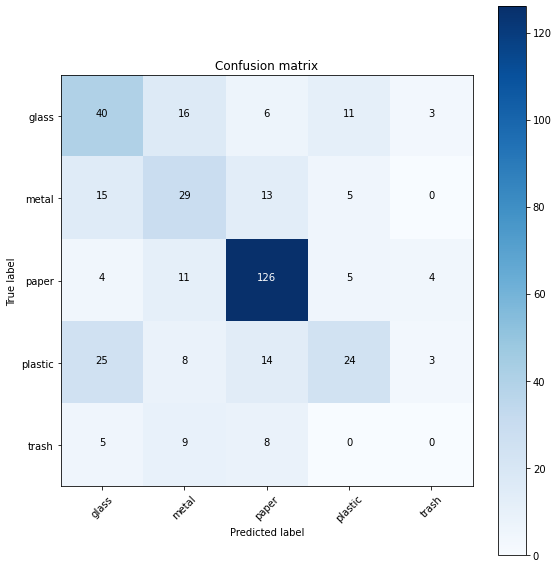

In [8]:
evaluate_model(
    model=robin_materials_model(),
    class_names=materials_dataset['class_names'],
    test_ds=materials_test_ds,
    log_dir=materials_log,
    training_tag=training_tag,
    cm_name="New Classifier",
    log_false_images=False
)

In [9]:
fine_tune_materials_model(
    robin_materials_model,
    materials_hyperparams,
    materials_dataset,
    log_dir=materials_logdir,
    training_tag=training_tag,
    history=history
)

Fine tuning
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280) 

12/12 [==============================] - 4s 325ms/step - loss: 0.5752 - accuracy: 0.8021

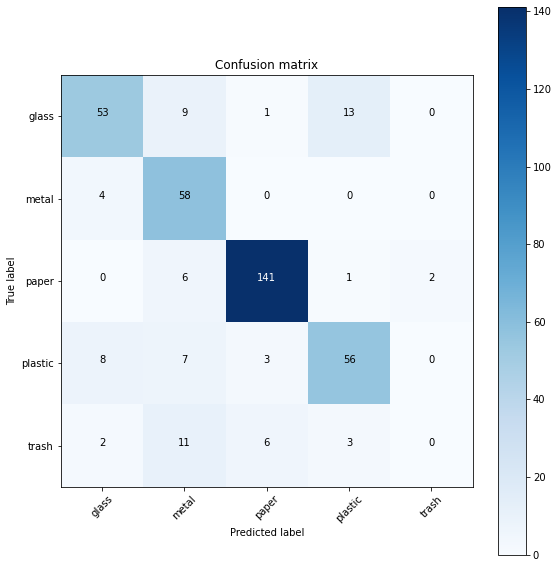

In [10]:
evaluate_model(
    model=robin_materials_model(),
    class_names=materials_dataset['class_names'],
    test_ds=materials_test_ds,
    log_dir=materials_log,
    training_tag=training_tag,
    cm_name="Fine Tune",
    log_false_images=True
)